# Influence functions for Computer vision

This notebook explores the use of influences functions for convolutional neural networks. In the first part we will fine-tune Resnet18 on the [tiny-imagenet dataset](https://huggingface.co/datasets/Maysee/tiny-imagenet). This dataset was first created for the [Stanford Deep Learning for Computer Vision](http://cs231n.stanford.edu/) course, and it contains a subset of the [famous ImageNet dataset](https://image-net.org/challenges/LSVRC/2012/index), (200 classes vs 1000, and images are downsampled to a lower-resolution, from 64x64 pixels to 256x256). 

After training the last layers of the network, we will use pyDVL to find the most and least influential points on the evaluation images. This can be used e.g. to explain errors in the inference of new images or to direct efforts for collecting new data. In the last part of the notebook we will also see that influence functions are an effective tool for finding anomalous or corrupted data points.

If you want to know more about the mathematical foundations of influence functions for neural networks, you can find a primer in the appendix to this notebook.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from notebook_support import (
    load_model,
    save_model,
    plot_sample_images,
    plot_top_bottom_if_images,
    plot_train_val_loss,
    corrupt_imagenet,
    load_preprocess_imagenet,
    plot_corrupted_influences_distribution,
    get_mean_corrupted_influences,
)
import os
import torch
from torch.optim import Adam
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from pydvl.influence.model_wrappers import TorchModel
from pydvl.influence.general import compute_influences
from pydvl.reporting.plots import plot_influence_distribution_by_label
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [3]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

## Constants

Let's fix some constants. Since models training and influence calculations take some time (~tens of minutes), they are cached. If you wish to use the saved values, set run_model_trainings and calculate_influences to False. If instead you want to run the full notebook, set them to True.

In [4]:
random_state = 42
is_CI = os.environ.get("CI")

if is_CI:
    hessian_reg = 1e4
else:
    hessian_reg = 1e-3

run_model_trainings = True

In [5]:
np.random.seed(random_state)

## Loading and preprocessing the dataset

The dataset is loaded through the load_preprocess_imagenet method. We will load the images related to the classes 90 and 100. This is an arbitrary choice and any other class would work. You can try selecting any other set of numbers, even more than just two (you could even select all 200 classes, though this will require longer training times).

In [6]:
labels_to_keep = [90, 100]
train_ds, val_ds, test_ds = load_preprocess_imagenet(
    train_size=0.8,
    test_size=0.1,
    keep_labels=labels_to_keep,
    is_CI=is_CI,
)

  0%|          | 0/100 [00:00<?, ?ba/s]

The load_preprocess_imagenet method returns three dataframes, containing data for train, val and test sets respectively. Let's take a look at their structure.

In [7]:
print("dataset keys", train_ds.keys())

dataset keys Index(['normalized_images', 'labels', 'images'], dtype='object')


Each dataset has three keys. One holds normalized images, the second holds the initial images, and the third their respective label. 

In [8]:
print("Normalised image type:", train_ds["normalized_images"][0].dtype)
print("Image object:", train_ds["images"][0])
print("Label type:", train_ds["labels"][0].dtype)

Normalised image type: torch.float32
Image object: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7F9FDBC92190>
Label type: int64


Let's take a closer look at a few image samples

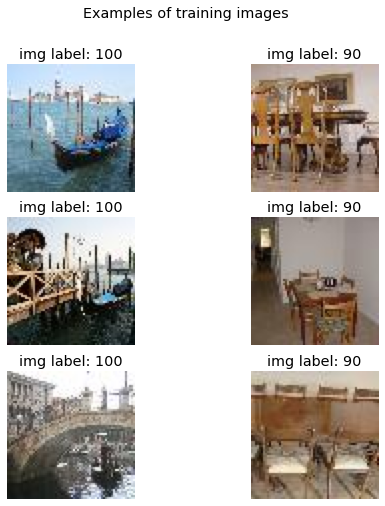

In [9]:
plot_sample_images(train_ds, n_images_per_class=3)

One class is related to dining tables, the other to boats and to Venice! We convert the labels to a more readable form in the next cell

In [10]:
numerical_labels_to_strings = {90: "tables", 100: "boats"}


def numerical_to_string_label(dataset):
    string_labels = [numerical_labels_to_strings[label] for label in dataset["labels"]]
    dataset["labels"] = string_labels


numerical_to_string_label(train_ds)
numerical_to_string_label(val_ds)
numerical_to_string_label(test_ds)

Let's now further pre-process the data and prepare for model training. The next cell converts the normalized image into a tensor and shifts the labels to sequential indices (i.e. [0, 1], to be used for training the classifier).

In [11]:
ds_label_to_model_label = {
    ds_label: idx for idx, ds_label in enumerate(numerical_labels_to_strings.values())
}
model_label_to_ds_label = {
    idx: ds_label for idx, ds_label in enumerate(numerical_labels_to_strings.values())
}


def process_io(x, y):
    x_nn = torch.stack(x.tolist())
    y_nn = [ds_label_to_model_label[yi] for yi in y]
    return x_nn, y_nn


train_x, train_y = process_io(train_ds["normalized_images"], train_ds["labels"])
val_x, val_y = process_io(val_ds["normalized_images"], val_ds["labels"])
test_x, test_y = process_io(test_ds["normalized_images"], test_ds["labels"])

## Model definition

In this part we will proceed with the initialization of the model. The model is defined by loading resnet18 and then re-defining the last few layers so that we can do binary classification on our selected classes.

In [12]:
def initialize_model(output_size):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    # Finetune final few layers
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, output_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


ce_loss = nn.CrossEntropyLoss()
model_ft = initialize_model(output_size=len(labels_to_keep))

Training is done through some pytorch convenience wrappers (TorchModel) which are part of pyDVL.

In [13]:
def train_model(model, num_epochs, training_data, lr=0.001):
    optimizer = Adam(model.parameters(), lr=lr)

    train_x, train_y = process_io(
        training_data["normalized_images"], training_data["labels"]
    )

    train_loss, val_loss = TorchModel(model=model).fit(
        x_train=train_x,
        y_train=train_y,
        x_val=val_x,
        y_val=val_y,
        loss=ce_loss,
        optimizer=optimizer,
        num_epochs=num_epochs,
        batch_size=1000,
    )
    return train_loss, val_loss

## Model training

We will train the model for 50 epochs and save the results. Then we will plot the train and validation loss curves.

In [14]:
if run_model_trainings:
    num_epochs = 50
    train_loss, val_loss = train_model(
        model_ft, num_epochs=num_epochs, training_data=train_ds
    )
    save_model(model_ft, train_loss, val_loss, model_name="model_ft")
else:
    train_loss, val_loss = load_model(model_ft, model_name="model_ft")

Model fitting:   0%|          | 0/50 [00:00<?, ?it/s]

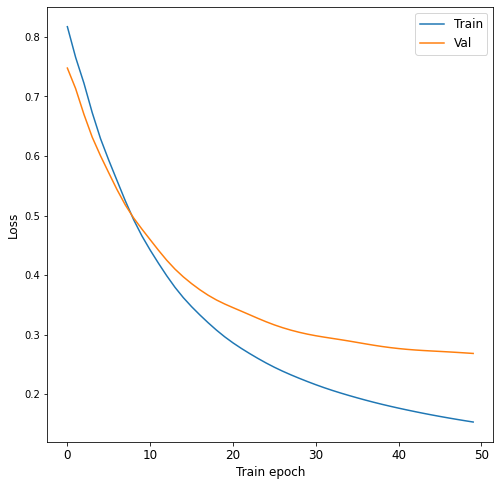

In [15]:
plot_train_val_loss(train_loss, val_loss)

Confusion matrix and f1 score are good, especially considering the low resolution of the images and their complexity (many different objects)

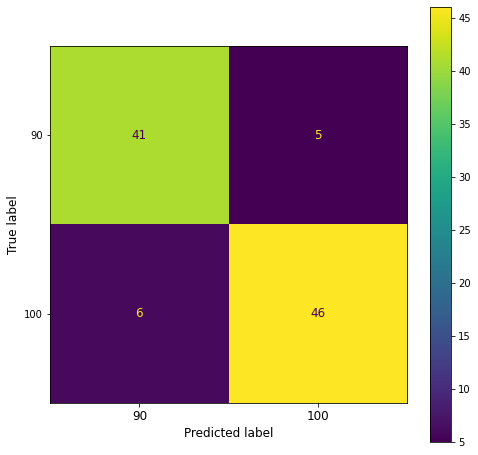

In [16]:
pred_y_test = np.argmax(model_ft(test_x).detach(), axis=1)

cm = confusion_matrix(test_y, pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_to_keep)
disp.plot();

In [17]:
model_score = f1_score(test_y, pred_y_test, average="weighted")
print("f1_score of model:", model_score)

f1_score of model: 0.8878136910887123


## Influence computation

Let's now calculate influences! The method compute_influences will take the trained model, a loss (which typically is the training loss, but not necessarily), some input dataset with labels (which typically is the training data, or a subset of it) and some test data (which in this case will be the test set).

Other important parameters are the Hessian regularization term, which should be chosen as small as possible for the computation to converge (further details on why this is important can be found in the appendix). 

Since Resnet18 is quite big, the inversion method that should be preferred is conjugate gradient ("cg"). The direct method would require a lot of memory. Finally, the influence type will be "up" (the other option, "perturbation", is beyond the scope of this notebook, but more info can be found in the influence_wine notebook or on the pyDVL documentation).

The output of calculate_influences is a matrix of size (test_set_length, training_set_length). Each row represents a test data point, and each column a training data point. Each entry (i,j) represents the influence of training point j on the test point i.

In [18]:
influences = compute_influences(
    model=model_ft,
    loss=ce_loss,
    x=train_x,
    y=train_y,
    x_test=test_x,
    y_test=test_y,
    hessian_regularization=hessian_reg,
    inversion_method="cg",
    influence_type="up",
    progress=True,
)

Split Gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Conjugate gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Split Gradient:   0%|          | 0/707 [00:00<?, ?it/s]

## Analysing influences

### Analysing the influence on a single test image

Let's take an image in the test set (try changing test_image_idx). 

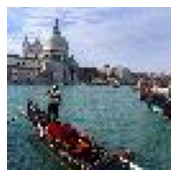

In [19]:
test_image_idx = 42
plt.rcParams["figure.figsize"] = (3, 3)
plt.imshow(test_ds["images"][test_image_idx])
plt.axis("off")
plt.show()

We can compare the predicted label with the real label with the following

In [20]:
print(
    "Predicted label:",
    model_label_to_ds_label[
        np.argmax(model_ft(test_x[test_image_idx].unsqueeze(0)).detach(), axis=1).item()
    ],
)
print("Real label:", test_ds["labels"][test_image_idx])

Predicted label: boats
Real label: boats


We next plot the histogram of the influences of the training data points, separated by their label. 

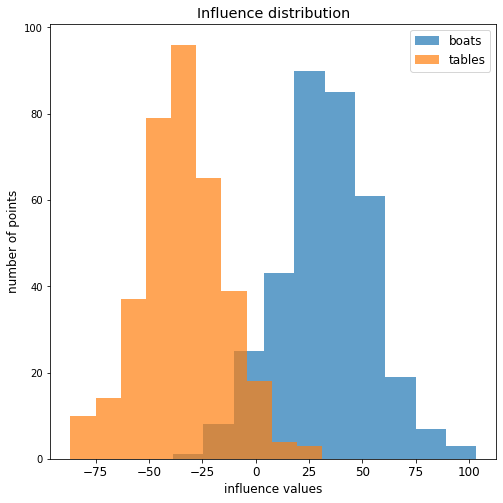

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
plot_influence_distribution_by_label(
    influences[test_image_idx], train_ds["labels"].values
)

Rather unsurprisingly, the training points that have the same label as the test image have, on average, a higher influence on the chosen test image. Let's then take the training images with the same label as the selected test image and visualize the images with the highest and lowest influences.

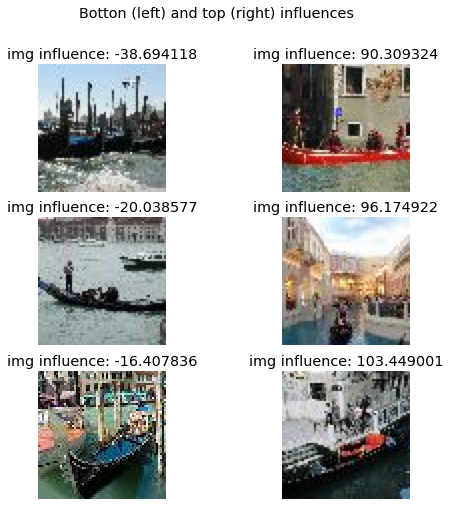

In [22]:
images_with_same_label = train_ds["labels"] == test_ds["labels"][test_image_idx]
influence_values_with_same_label = influences[test_image_idx][images_with_same_label]
images_same_label = train_ds["images"][images_with_same_label].values
plot_top_bottom_if_images(
    influence_values_with_same_label, subset_images=images_same_label, num_to_plot=3
)

Looking at the images, it is difficult to explain why those on the right are more influential than those on the left. At first sight, the choice seems to be random (or at the very least noisy). Let's dig in a bit more by analyzing the average influence on test samples.

## Analysing the average influence on test samples

By taking the average across the rows of the influence matrix, we get the average influence of each training sample on the test dataset.

In [23]:
avg_influences = np.mean(influences, axis=0)

Once again, let's plot the histogram of influence values by label.

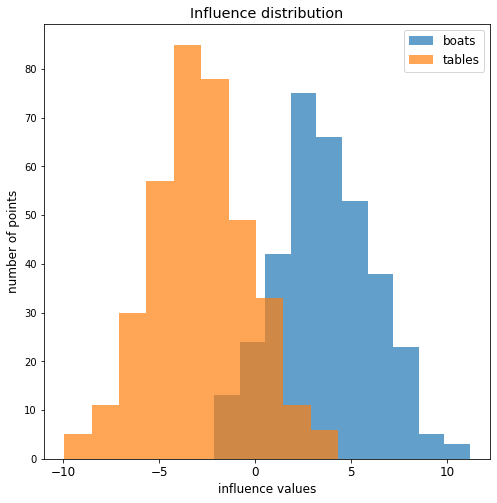

In [24]:
plot_influence_distribution_by_label(avg_influences, train_ds["labels"].values)

Next, for each class (you can change value by changing label key) we can have a look at the top and bottom images by average influence, i.e. we can show the images that on average have the highest and lowest influence on the test images. 

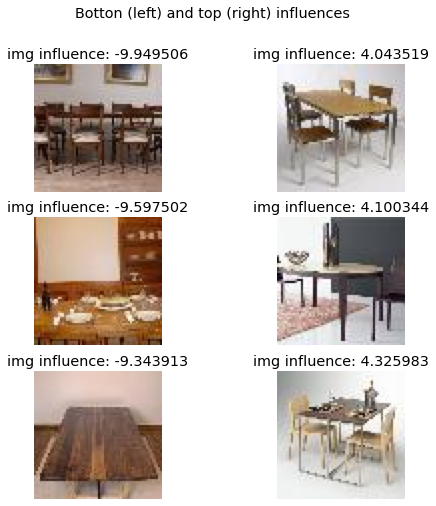

In [25]:
label = "tables"
img_with_selected_label = train_ds["labels"] == label
if_selected_label = avg_influences[img_with_selected_label]
imges_same_label = train_ds["images"][img_with_selected_label].values
plot_top_bottom_if_images(if_selected_label, imges_same_label, num_to_plot=3)

Once again, it is not easy to explain why the images on the left have a more negative influence wrt. the ones on the right. One could argue that in order to predict that there is a dining table in the image it is beneficial to clearly see both the chairs and the table itself, which is missing in some of the samples on the left. Also, color seems to be a discriminant: houses with a blue painting could get confused with the water around a boat. Of course, this is debatable and different people could come up with other explanations *a posteriori*.

Nevertheless, influence functions can be provably used to detect the points which are corrupted or which have been wrongly labelled. As such, they are an effective way to "debug" the training dataset. The next sections will run a few experiments on this matter.

## Analysing the influence of corrupted data

In the next cell we train a new model (with the same exact architecture as before), on a dataset with some corrupted labels. The method get_corrupted_imagenet will take the training dataset and corrupt a certain fraction of the labels. This means that it will take a few samples of the label 90 (the dining table) and switch the label to 100 (boats and Venice) without changing in any way the input image. Then we will train the new model with the same number of epochs and optimizer as the earlier model.

In [26]:
model_corrupted = initialize_model(output_size=len(labels_to_keep))
corrupted_dataset, corrupted_indices = corrupt_imagenet(
    dataset=train_ds,
    fraction_to_corrupt=0.1,
    avg_influences=avg_influences,
)

if run_model_trainings:
    num_epochs = 50
    train_loss, val_loss = train_model(
        model_corrupted,
        num_epochs=num_epochs,
        training_data=corrupted_dataset,
    )
    save_model(model_corrupted, train_loss, val_loss, model_name="model_corrupted")
else:
    train_loss, val_loss = load_model(model_corrupted, model_name="model_corrupted")

Model fitting:   0%|          | 0/50 [00:00<?, ?it/s]

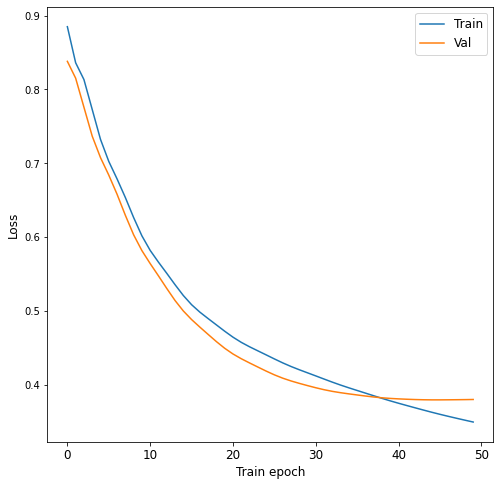

In [27]:
plot_train_val_loss(train_loss, val_loss)

In [28]:
pred_y_test = np.argmax(model_corrupted(test_x).detach(), axis=1)
model_score = f1_score(test_y, pred_y_test, average="weighted")
print("f1 score of model with corrupted data:", model_score)

f1 score of model with corrupted data: 0.8062233953250153


Interestingly, despite being trained on a corrupted dataset, the model has a fairly high f1_score. Let's now calculate the influence of  the corrupted training data points over the test data points.

In [34]:
corrupted_train_x, corrupted_train_y = process_io(
    corrupted_dataset["normalized_images"],
    corrupted_dataset["labels"],
)
influences = compute_influences(
    model=model_corrupted,
    loss=ce_loss,
    x=corrupted_train_x,
    y=corrupted_train_y,
    x_test=test_x,
    y_test=test_y,
    hessian_regularization=hessian_reg,
    inversion_method="cg",
    influence_type="up",
    progress=True,
)

Split Gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Conjugate gradient:   0%|          | 0/98 [00:00<?, ?it/s]

Split Gradient:   0%|          | 0/707 [00:00<?, ?it/s]

As before, since we are interested in the average influence on the test dataset, we take the average of influences across rows, and then plot the highest and lowest influences for a chosen label

In [35]:
avg_corrupted_influences = np.mean(influences, axis=0)

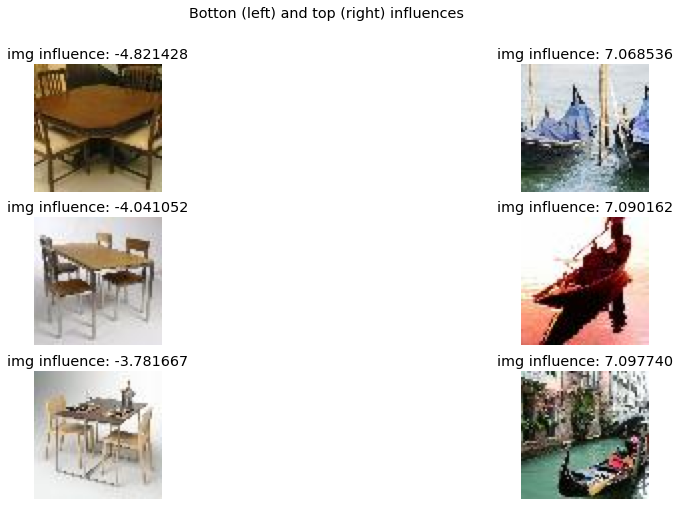

In [36]:
label = "boats"
img_with_selected_label = corrupted_dataset["labels"] == label
if_selected_label = avg_corrupted_influences[img_with_selected_label]
imges_same_label = corrupted_dataset["images"][img_with_selected_label].values
plot_top_bottom_if_images(if_selected_label, imges_same_label, num_to_plot=3)

As expected, the lowest influence samples for the "boats" label are those that have been corrupted: all the images on the left are tables! We can compare the average influence of corrupted data with non-corrupted ones

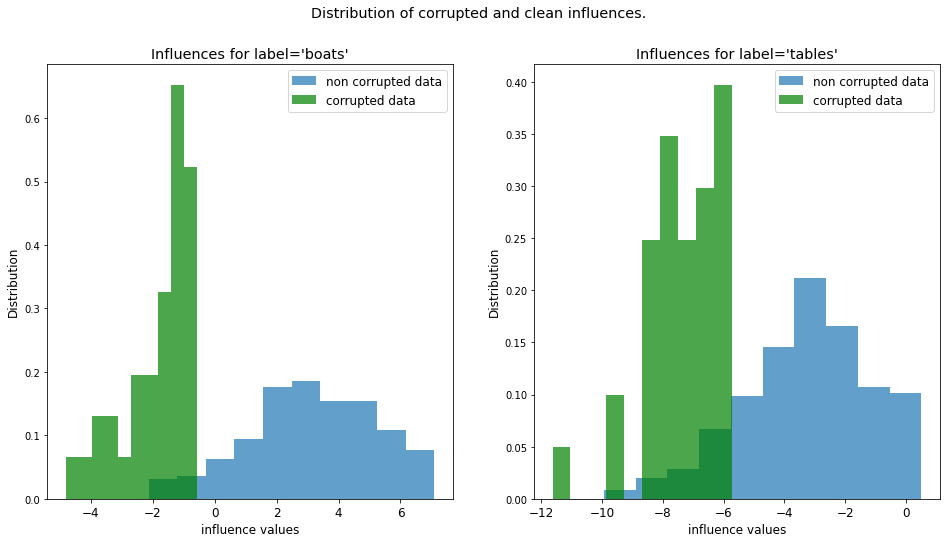

In [37]:
plt.rcParams["figure.figsize"] = (16, 8)
plot_corrupted_influences_distribution(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences
)

In [38]:
get_mean_corrupted_influences(
    corrupted_dataset, corrupted_indices, avg_corrupted_influences
)

,label,avg_non_corrupted_infl,avg_corrupted_infl,score_diff
0,boats,3.176763,-1.831417,5.008180
1,tables,-3.289284,-7.384306,4.095022


And indeed corrupted data on average have a more negative influence than clean ones!

Despite this being a useful property, influence functions are known to be a noisy estimate of data valuation, especially in deep learning. A lot of factors (e.g. the size of the network, the training process or the Hessian regularization term) can interfere with the computation, to the point that often the results that we obtain are not very reliable. This has been studied extensively in a recent paper:

*Basu, S., P. Pope, and S. Feizi. [Influence Functions in Deep Learning Are Fragile.](https://par.nsf.gov/servlets/purl/10315557) International Conference on Learning Representations (ICLR). 2021*.

Nevertheless, influence functions offer a relatively quick and mathematically rigorous way to evaluate (at first order) the importance of a training point on models' prediction. 

## Appendix: Theory of Influence functions for neural networks

In this appendix we will briefly go through the essential formulas that lay the foundations of influence functions for neural networks. A more in-depth and expanded analysis can be found on the original paper:

Koh, Pang Wei, and Percy Liang. ["Understanding Black-box Predictions via Influence Functions"](https://arxiv.org/pdf/1703.04730.pdf) International conference on machine learning. PMLR, 2017.

### Upweighting points

Let's start by considering some input space $\mathcal{X}$ to a model (e.g. images) and an output space $\mathcal{Y}$ (e.g. labels). Let's take $z_i = (x_i, y_i)$ to be the $i$-th training point, and $\theta$ to be the (potentially highly) multi-dimensional parameters of the neural network (i.e. $\theta$ is a big array with very many parameters). We will indicate with $L(z, \theta)$ the loss of the model for point $z$ and parameters $\theta$. When training the model we minimize the loss over all points, i.e. the optimal parameters are calculated through gradient descent on the following formula:
$$
\hat{\theta} = \arg \min_\theta \frac{1}{n}\sum_{i=1}^n L(z_i, \theta)
$$
where $n$ is the total number of training data points.

For notation convenience, let's define
 $$
\hat{\theta}_{-z} = \arg \min_\theta \frac{1}{n}\sum_{z_i \ne z} L(z_i, \theta) \ ,
$$
i.e. $\hat{\theta}_{-z}$ are the model parameters that minimize the total loss when $z$ is not in the training dataset. 

In order to check the impact of each training point on the model, we would need to calculate $\hat{\theta}_{-z}$ for each $z$ in the training dataset, thus re-training the model at least ~$n$ times (more if model training is noisy). This is computationally very expensive, especially for big neural networks.

To circumvent this problem, we can just calculate a first order approximation of $\hat{\theta}$. This can be done through single backpropagation and without re-training the full model. 

Let's define
$$
\hat{\theta}_{\epsilon, z} = \arg \min_\theta \frac{1}{n}\sum_{i=1}^n L(z_i, \theta) + \epsilon L(z, \theta) \ ,
$$
which is the optimal $\hat{\theta}$ if we were to up-weigh $z$ by an amount $\epsilon$. 

From a classical result (details at *Cook, R. D. and Weisberg, S. [Residuals and influence in
regression](https://onlinelibrary.wiley.com/doi/abs/10.1002/bimj.4710270110). New York: Chapman and Hall, 1982*), we know that:
$$
\frac{d \ \hat{\theta}_{\epsilon, z}}{d \epsilon} = -H_{\hat{\theta}}^{-1} \nabla_\theta L(z, \hat{\theta})
$$
where $H_{\hat{\theta}} = \frac{1}{n} \sum_{i=1}^n \nabla_\theta^2 L(z_i, \hat{\theta})$ is the Hessian of $L$. Importantly, notice that this expression is only valid when $\hat{\theta}$ is a minimum of $L$, or otherwise $H_{\hat{\theta}}$ cannot be inverted!

### Approximating points' influence

We will define the influence of training point $z$ on test point $z_{\text{test}}$ as $\mathcal{I}(z, z_{\text{test}}) =  L(z_{\text{test}}, \hat{\theta}_{-z}) - L(z_{\text{test}}, \hat{\theta})$ (notice that it is higher for points $z$ which positively impact the model score, since if they are excluded, the loss is higher). In practice, however, we will always use the infinitesimal approximation $\mathcal{I}_{up}(z, z_{\text{test}})$, defined as
$$
 \mathcal{I}_{up}(z, z_{\text{test}}) = - \frac{d L(z_{\text{test}}, \hat{\theta}_{\epsilon, z})}{d \epsilon} \Big|_{\epsilon=0}
$$

Using the chain rule and the results calculated above, we thus have:
$$
 \mathcal{I}_{up}(z, z_{\text{test}}) = - \nabla_\theta L(z_{\text{test}}, \hat{\theta})^\top \ \frac{d \hat{\theta}_{\epsilon, z}}{d \epsilon} \Big|_{\epsilon=0} = \nabla_\theta L(z_{\text{test}}, \hat{\theta})^\top \ H_{\hat{\theta}}^{-1} \ \nabla_\theta L(z, \hat{\theta})
$$

In order to calculate this expression we need the gradient and the Hessian of the loss wrt. the model parameters $\hat{\theta}$. This can be easily done through a single backpropagation pass.

### Regularizing the Hessian

One very important assumption that we make when approximating influence is that $\hat{\theta}$ is a (at least local) minimum of the loss. However, during neural networks' training many factors, such as the noise in SGD or a non-small enough learning rate, may interfere with us reaching the actual minimum. In this scenario, calculating and inverting the Hessian may become infeasible (the computation diverges and returns random values).

To prevent this from happening, instead of inverting the true Hessian $H_{\hat{\theta}}$, in our computation we invert $H_{\hat{\theta}} + \lambda \mathbb{I}$, with $\mathbb{I}$ being the identity matrix with same shape as $H$. This is a trick that makes sure that the eigenvalues of $H_{\hat{\theta}}$ are non-null and that the matrix is invertible. In order for regularization not to interfere too much with influence calculation, the regularization parameter $\lambda$ should therefore be as small as possible, but also big enough so that the inversion of $H_{\hat{\theta}} + \lambda \mathbb{I}$ is stable. 